<a href="https://colab.research.google.com/github/yoneda-kg/sparce/blob/main/ISTA%2C_AMP%2C_OAMP_test(SNR)2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import time
import jax
import numpy as np
from scipy.stats import norm
from jax.scipy.stats import norm as normal
from scipy.stats import ortho_group
import matplotlib.pyplot as plt

In [2]:
from sympy import *
from sympy.abc import *
import cupy as cp
import csv
import pprint

In [3]:
class Base:
    def __init__(self, M, N):
        self.M = M
        self.N = N
        self.A = np.hstack((np.eye(M), np.zeros((M, N-M))))

In [4]:
class iidGaussian(Base):
    def __init__(self, M, N, m=0, v=1):
        super().__init__(M, N)
        self.A = self.set_matrix(M, N, m, v)

    def set_matrix(self, row, column, mean, var):
        """
        Return i.i.d(independent and identically distributed) Gaussian Matrix
        """
        return np.random.normal(mean, var**0.5, (row, column))

In [5]:
class UniInvar(Base):
    def __init__(self, M, N, cond):
        super().__init__(M, N)
        self.kappa = cond
        self.r = cond**(1/M)
        self.sv = self.singular_value()
        self.Sigma = np.hstack((np.diag(self.sv), np.zeros((M, N-M))))
        self.V = ortho_group.rvs(M)
        self.U = ortho_group.rvs(N)
        self.A = self.V @ self.Sigma @ self.U.T

    def singular_value(self):
        start = self.N * (1 - 1/self.r) / (1 - 1/self.kappa) if self.kappa != 1 else self.N/self.M
        sv = np.array([start])
        for i in range(self.M-1):
            sv = np.append(sv, sv[-1] / self.r)
        return sv

    def change_cond(self, cond):
        self.kappa = cond
        self.r = cond**(1/self.M)
        self.sv = self.singular_value()
        self.Sigma = np.hstack((np.diag(self.sv), np.zeros((self.M, self.N - self.M))))
        self.A = self.V @ self.Sigma @ self.U.T

In [6]:
def bernouli_gaussian(n, rho):
    """
    generation of signal according to Bernouli_Gaussian distribution
    """
    rand = np.random.rand(n)
    x = np.zeros((n, 1))
    for i in range(n):
        if rand[i] < rho/2:
            x[i] = norm.ppf(rand[i]/rho, loc=0, scale=1/rho**0.5)
        elif 1 - rho/2 < rand[i]:
            x[i] = norm.ppf((rand[i] - (1-rho))/rho, loc=0, scale=1/rho**0.5)
    return x

In [7]:
def soft_threshold(x, ganma):
    """
    soft-thresholding function
    """
    return np.maximum(np.abs(x) - ganma, 0.0) * np.sign(x)

def df(r, gamma):
    """
    divergence-free function
    """
    eta = soft_threshold(r, gamma)
    return eta - np.mean(eta != 0) * r

In [8]:
def plt_MSE(mse, label, T, color=None, linestyle=None):
    step = np.arange(0, T+1, 5)

    plt.grid()
    plt.xlabel("iteration")
    plt.ylabel("MSE")
    plt.xticks(step)
    plt.ylim(1e-7, 1e+1)
    plt.yscale('log')

    plt.plot(mse, label=label, color=color, linestyle=linestyle)
    plt.legend()

In [9]:
class ISTA:
    def __init__(self, A, x, SNR):
      self.A=A
      self.M, self.N=A.shape
      self.x=x
      Ax=np.dot(A, x)
      self.SNR=SNR
      SNRdB = 10**(0.1*SNR)
      self.sigma = np.var(Ax) / SNRdB
      self.n = np.random.normal(0, self.sigma**0.5, (self.M, 1))

      self.y=Ax+self.n
      self.s=np.zeros((self.N, 1))
      self.mse=np.array([None])
      self.atai=np.array([None])
      self.AT=np.transpose(A)
      self.ATA=self.AT@self.A

    def estimate(self, T=20, tau=0.5):
      L=self.__set__lipchitz()
      ganma=1/(tau*L)
      for _ in range(T):
        r=self._update_r()
        w=self._update_w(ganma, r)
        self.s=self._update_s(w, 1/L)
        self.mse=self._add_mse()
        self.atai = self._add_atai(w, 1/L)

    def __set__lipchitz(self):
      L=np.linalg.norm(self.AT.dot(self.A),ord=2)/(0.5)
      return L

    def _update_r(self):
      return self.y - np.dot(self.A, self.s)

    def _update_w(self, ganma, r):
      return self.s + ganma * np.dot(self.AT, r)

    def _update_s(self, w, thre):
      return soft_threshold(w, thre)

    def _add_atai(self, w, thre):
      atai = soft_threshold(w, thre)
      self.atai = np.append(self.atai, atai)
      return self.atai

    def _add_mse(self):
      mse = np.linalg.norm(self.s - self.x)**2 / self.N
      self.mse=np.append(self.mse, mse)
      return self.mse

    def result(self):
      plt.plot(self.x.real)
      plt.plot(self.s.real)
      plt.grid()

    def result_MSE(self):
      Figure, ax = plt.subplots()#グラフオブジェクトを生成
      plt.xlabel('iteration')
      plt.ylabel('MSE[log10]')
      ite = np.shape(self.mse)[0]
      ax.set_ylim([0.0000001,1])
      plt.yscale('log')
      plt.xticks(np.arange(0, ite, 1))
      result = np.array([mse if mse is not None else None for mse in self.mse])
      plt.plot(result)
      plt.grid()

    def result_atai(self):
      print(self.atai)
      Figure, ax = plt.subplots()#グラフオブジェクトを生成
      plt.xlabel('iteration')
      plt.ylabel('MSE[log10]')
      itee = np.shape(self.atai)[0]
      plt.xticks(np.arange(0, itee, 1))
      resulta = np.array([atai if atai is not None else None for atai in self.atai])
      plt.plot(resulta)
      plt.grid()

In [10]:
class AMP(ISTA):
    def __init__(self, A, x, SNR):
      super().__init__(A, x, SNR)
      self.tau=np.array([None])
      self.v=[None]


    def estimate(self, T=20):
      Onsager=np.zeros((self.M, 1))
      for _ in range(T):
        r=self._update_r()
        w=self._update_w(r+Onsager)
        tau=self._update_tau(r+Onsager)
        self.s=self._update_s(w, tau)
        Onsager=np.sum(self.s != 0)/self.M*(r+Onsager)
        self.mse=self._add_mse()

    def _update_v(self, r):
      v = (np.linalg.norm(r)**2 - self.M * self.sigma) / np.trace(self.ATA)
      if v<0:
        v=1.e-4
      self.v.append(v)
      return v

    def _update_w(self, r):
       return self.s+np.dot(self.AT, r)

    def _update_tau(self, r):
        tau = np.linalg.norm(r)**2 / self.M
        np.append(self.tau, tau)
        return tau

    def _update_s(self, w, tau):
      return soft_threshold(w, pow(tau, 0.5))

In [52]:
class OAMP(AMP):
    def __init__(self, A, x, SNR):
      super().__init__(A, x, SNR)
      self.AAT=A@A.T
      self.I=np.eye(self.M)

    def estimate(self, T=20, ord='MF'):
      v=self._update_v(self.y)
      self.v.pop()
      self.W=self.__set_W(v, ord)

      I=np.eye(self.N)
      B=I-self.W @ self.A
      self.trW2=np.trace(self.W @ self.W.T)
      self.trB2=np.trace(B @ B.T)

      for t in range(T):
        r = self._update_r()
        w = self._update_w(r)
        v = self._update_v(r)
        tau = self._update_tau(v)
        self.s, message = self._update_s(w, tau)
        print(f"{t+1}/{T}")
        print(f"tau = {tau}")
        print(f"v = {v}")
        print(f"w = {w}")
        print(f"r = {r}")
        print(message)
        print("="*42)
        np.savetxt("history_MFw.csv",            # ファイル名
           X=w,                  # 保存したい配列
           delimiter=","            # 区切り文字
        )
        np.savetxt("history_MFr.csv",            # ファイル名
           X=r,                  # 保存したい配列
           delimiter=","            # 区切り文字
        )
        self._add_mse()
        if t == T-1: break
        if ord == 'LMMSE':
          self.W = self.__set_W(v, ord='LMMSE')
          B = np.eye(self.N) - self.W @ self.A
          self.trW2 = np.trace(self.W @ self.W.T)
          self.trB2 = np.trace(B @ B.T)

    def __set_W(self, v, ord):
      if ord == 'MF':
        W_ = self.AT
      elif ord == 'PINV':
        W_ = np.linalg.pinv(self.A)
      elif ord == 'LMMSE':
        W_ = v * self.AT @ np.linalg.inv(v * self.AAT + self.sigma * self.I)
      else :
        raise NameError("not correct")
      return self.N / np.trace(W_ @ self.A) * W_

    def _update_w(self, r):
      return self.s + self.W @ r

    def _update_tau(self, v):
      return 1/self.N * (self.trB2 * v + self.trW2 * self.sigma)

    def _update_s(self, w, tau):
      #all=np,sum(soft_threshold(w, tau**0.5) != 0) + np.sum(soft_threshold(w, tau**0.5) == 0)
      rho = np.sum(soft_threshold(w, tau**0.5) != 0) /(np.sum(soft_threshold(w, tau**0.5) != 0) + np.sum(soft_threshold(w, tau**0.5) == 0))
      #rho = np.mean(soft_threshold(w, tau**0.5) != 0)
      def func_mmse(vector, threshold):
          xi = rho**(-1) + threshold
          top = normal.pdf(vector, loc=0, scale=xi**0.5) / xi
          bottom = rho * normal.pdf(vector, loc=0, scale=xi**0.5) + (1-rho) * normal.pdf(vector, loc=0, scale=threshold**0.5)
          return top / bottom * vector

      dfunc_mmse = jax.vmap(jax.grad(func_mmse, argnums=(0)), (0, None))
      reshaped_w = w.reshape(self.N)
      v_mmse = tau**0.5 * np.mean(dfunc_mmse(reshaped_w, tau))
      C_mmse = tau**0.5 / (tau**0.5 - v_mmse)
      message = f",{rho}"
      return C_mmse * (func_mmse(w, tau) - np.mean(dfunc_mmse(reshaped_w, tau)) * w), message


In [42]:
class OAMP_PINV(AMP):
    def __init__(self, A, x, SNR):
      super().__init__(A, x, SNR)
      self.AAT=A@A.T
      self.I=np.eye(self.M)

    def estimate(self, T=20, ord='PINV'):
      v=self._update_v(self.y)
      self.v.pop()
      self.W=self.__set_W(v, ord)

      I=np.eye(self.N)
      B=I-self.W @ self.A
      self.trW2=np.trace(self.W @ self.W.T)
      self.trB2=np.trace(B @ B.T)

      for t in range(T):
        r = self._update_r()
        w = self._update_w(r)
        v = self._update_v(r)
        tau = self._update_tau(v)
        self.s, message = self._update_s(w, tau)
        print(f"{t+1}/{T}")
        print(f"tau = {tau}")
        print(f"v = {v}")
        print(f"w = {w}")
        print(f"r = {r}")
        print(message)
        print("="*42)
        np.savetxt("history_MFw.csv",            # ファイル名
           X=w,                  # 保存したい配列
           delimiter=","            # 区切り文字
        )
        np.savetxt("history_MFr.csv",            # ファイル名
           X=r,                  # 保存したい配列
           delimiter=","            # 区切り文字
        )
        self._add_mse()
        if t == T-1: break
        if ord == 'LMMSE':
          self.W = self.__set_W(v, ord='LMMSE')
          B = np.eye(self.N) - self.W @ self.A
          self.trW2 = np.trace(self.W @ self.W.T)
          self.trB2 = np.trace(B @ B.T)

    def __set_W(self, v, ord):
      if ord == 'MF':
        W_ = self.AT
      elif ord == 'PINV':
        W_ = np.linalg.pinv(self.A)
      elif ord == 'LMMSE':
        W_ = v * self.AT @ np.linalg.inv(v * self.AAT + self.sigma * self.I)
      else :
        raise NameError("not correct")
      return self.N / np.trace(W_ @ self.A) * W_

    def _update_w(self, r):
      return self.s + self.W @ r

    def _update_tau(self, v):
      return 1/self.N * (self.trB2 * v + self.trW2 * self.sigma)

    def _update_s(self, w, tau):
      rho = np.mean(soft_threshold(w, tau**0.5) != 0)
      def func_mmse(vector, threshold):
          xi = rho**(-1) + threshold
          top = normal.pdf(vector, loc=0, scale=xi**0.5) / xi
          bottom = rho * normal.pdf(vector, loc=0, scale=xi**0.5) + (1-rho) * normal.pdf(vector, loc=0, scale=threshold**0.5)
          return top / bottom * vector

      dfunc_mmse = jax.vmap(jax.grad(func_mmse, argnums=(0)), (0, None))
      reshaped_w = w.reshape(self.N)
      v_mmse = tau**0.5 * np.mean(dfunc_mmse(reshaped_w, tau))
      C_mmse = tau**0.5 / (tau**0.5 - v_mmse)
      message = f",{rho}"
      return C_mmse * (func_mmse(w, tau) - np.mean(dfunc_mmse(reshaped_w, tau)) * w), message


In [43]:
class OAMP_LMMSE(AMP):
    def __init__(self, A, x, SNR):
      super().__init__(A, x, SNR)
      self.AAT=A@A.T
      self.I=np.eye(self.M)

    def estimate(self, T=20, ord='LMMSE'):
      v=self._update_v(self.y)
      self.v.pop()
      self.W=self.__set_W(v, ord)

      I=np.eye(self.N)
      B=I-self.W @ self.A
      self.trW2=np.trace(self.W @ self.W.T)
      self.trB2=np.trace(B @ B.T)

      for t in range(T):
        r = self._update_r()
        w = self._update_w(r)
        v = self._update_v(r)
        tau = self._update_tau(v)
        self.s, message = self._update_s(w, tau)
        print(f"{t+1}/{T}")
        print(f"tau = {tau}")
        print(f"v = {v}")
        print(f"w = {w}")
        print(f"r = {r}")
        print(message)
        print("="*42)
        np.savetxt("history_MFw.csv",            # ファイル名
           X=w,                  # 保存したい配列
           delimiter=","            # 区切り文字
        )
        np.savetxt("history_MFr.csv",            # ファイル名
           X=r,                  # 保存したい配列
           delimiter=","            # 区切り文字
        )
        self._add_mse()
        if t == T-1: break
        if ord == 'LMMSE':
          self.W = self.__set_W(v, ord='LMMSE')
          B = np.eye(self.N) - self.W @ self.A
          self.trW2 = np.trace(self.W @ self.W.T)
          self.trB2 = np.trace(B @ B.T)

    def __set_W(self, v, ord):
      if ord == 'MF':
        W_ = self.AT
      elif ord == 'PINV':
        W_ = np.linalg.pinv(self.A)
      elif ord == 'LMMSE':
        W_ = v * self.AT @ np.linalg.inv(v * self.AAT + self.sigma * self.I)
      else :
        raise NameError("not correct")
      return self.N / np.trace(W_ @ self.A) * W_

    def _update_w(self, r):
      return self.s + self.W @ r

    def _update_tau(self, v):
      return 1/self.N * (self.trB2 * v + self.trW2 * self.sigma)

    def _update_s(self, w, tau):
      rho = np.mean(soft_threshold(w, tau**0.5) != 0)
      def func_mmse(vector, threshold):
          xi = rho**(-1) + threshold
          top = normal.pdf(vector, loc=0, scale=xi**0.5) / xi
          bottom = rho * normal.pdf(vector, loc=0, scale=xi**0.5) + (1-rho) * normal.pdf(vector, loc=0, scale=threshold**0.5)
          return top / bottom * vector

      dfunc_mmse = jax.vmap(jax.grad(func_mmse, argnums=(0)), (0, None))
      reshaped_w = w.reshape(self.N)
      v_mmse = tau**0.5 * np.mean(dfunc_mmse(reshaped_w, tau))
      C_mmse = tau**0.5 / (tau**0.5 - v_mmse)
      message = f",{rho}"
      return C_mmse * (func_mmse(w, tau) - np.mean(dfunc_mmse(reshaped_w, tau)) * w), message


非零成分の割合が既知

In [ ]:
class OAMP2(AMP):
    def __init__(self, A, x, SNR):
      super().__init__(A, x, SNR)
      self.AAT=A@A.T
      self.I=np.eye(self.M)

    def estimate(self, T=20, ord='MF'):
      v=self._update_v(self.y)
      self.v.pop()
      self.W=self.__set_W(v, ord)

      I=np.eye(self.N)
      B=I-self.W @ self.A
      self.trW2=np.trace(self.W @ self.W.T)
      self.trB2=np.trace(B @ B.T)
      history_v=[]
      history_tau=[]
      history_w=[]
      history_rho=[]
      history_r=[]

      for t in range(T):
        r = self._update_r()
        w = self._update_w(r)
        v = self._update_v(r)
        tau = self._update_tau(v)
        self.s, message = self._update_s(w, tau)
        np.append(history_v, v)
        np.append(history_tau, tau)
        np.append(history_w, w)
        np.append(history_rho, message)
        np.append(history_r, r)
        self._add_mse()
        if t == T-1: break
        if ord == 'LMMSE':
          self.W = self.__set_W(v, ord='LMMSE')
          B = np.eye(self.N) - self.W @ self.A
          self.trW2 = np.trace(self.W @ self.W.T)
          self.trB2 = np.trace(B @ B.T)

    def __set_W(self, v, ord):
      if ord == 'MF':
        W_ = self.AT
      elif ord == 'PINV':
        W_ = np.linalg.pinv(self.A)
      elif ord == 'LMMSE':
        W_ = v * self.AT @ np.linalg.inv(v * self.AAT + self.sigma * self.I)
      else :
        raise NameError("not correct")
      return self.N / np.trace(W_ @ self.A) * W_

    def _update_w(self, r):
      return self.s + self.W @ r

    def _update_tau(self, v):
      return 1/self.N * (self.trB2 * v + self.trW2 * self.sigma)

    def _update_s(self, w, tau):
      rho = 0.2
      def func_mmse(vector, threshold):
          xi = rho**(-1) + threshold
          top = normal.pdf(vector, loc=0, scale=xi**0.5) / xi
          bottom = rho * normal.pdf(vector, loc=0, scale=xi**0.5) + (1-rho) * normal.pdf(vector, loc=0, scale=threshold**0.5)
          return top / bottom * vector

      dfunc_mmse = jax.vmap(jax.grad(func_mmse, argnums=(0)), (0, None))
      reshaped_w = w.reshape(self.N)
      v_mmse = tau**0.5 * np.mean(dfunc_mmse(reshaped_w, tau))
      C_mmse = tau**0.5 / (tau**0.5 - v_mmse)
      message = f"rho = {rho}"
      return C_mmse * (func_mmse(w, tau) - np.mean(dfunc_mmse(reshaped_w, tau)) * w), message


In [ ]:
class OAMP_PINV2(AMP):
    def __init__(self, A, x, SNR):
      super().__init__(A, x, SNR)
      self.AAT=A@A.T
      self.I=np.eye(self.M)

    def estimate(self, T=20, ord='PINV'):
      v=self._update_v(self.y)
      self.v.pop()
      self.W=self.__set_W(v, ord)

      I=np.eye(self.N)
      B=I-self.W @ self.A
      self.trW2=np.trace(self.W @ self.W.T)
      self.trB2=np.trace(B @ B.T)

      for t in range(T):
        r = self._update_r()
        w = self._update_w(r)
        v = self._update_v(r)
        tau = self._update_tau(v)
        self.s, message = self._update_s(w, tau)
        print(message)
        print("="*42)
        self._add_mse()
        if t == T-1: break
        if ord == 'LMMSE':
          self.W = self.__set_W(v, ord='LMMSE')
          B = np.eye(self.N) - self.W @ self.A
          self.trW2 = np.trace(self.W @ self.W.T)
          self.trB2 = np.trace(B @ B.T)

    def __set_W(self, v, ord):
      if ord == 'MF':
        W_ = self.AT
      elif ord == 'PINV':
        W_ = np.linalg.pinv(self.A)
      elif ord == 'LMMSE':
        W_ = v * self.AT @ np.linalg.inv(v * self.AAT + self.sigma * self.I)
      else :
        raise NameError("not correct")
      return self.N / np.trace(W_ @ self.A) * W_

    def _update_w(self, r):
      return self.s + self.W @ r

    def _update_tau(self, v):
      return 1/self.N * (self.trB2 * v + self.trW2 * self.sigma)

    def _update_s(self, w, tau):
      rho = 0.2
      def func_mmse(vector, threshold):
          xi = rho**(-1) + threshold
          top = normal.pdf(vector, loc=0, scale=xi**0.5) / xi
          bottom = rho * normal.pdf(vector, loc=0, scale=xi**0.5) + (1-rho) * normal.pdf(vector, loc=0, scale=threshold**0.5)
          return top / bottom * vector

      dfunc_mmse = jax.vmap(jax.grad(func_mmse, argnums=(0)), (0, None))
      reshaped_w = w.reshape(self.N)
      v_mmse = tau**0.5 * np.mean(dfunc_mmse(reshaped_w, tau))
      C_mmse = tau**0.5 / (tau**0.5 - v_mmse)
      message = f"rho = {rho}"
      return C_mmse * (func_mmse(w, tau) - np.mean(dfunc_mmse(reshaped_w, tau)) * w), message


In [ ]:
class OAMP_LMMSE2(AMP):
    def __init__(self, A, x, SNR):
      super().__init__(A, x, SNR)
      self.AAT=A@A.T
      self.I=np.eye(self.M)

    def estimate(self, T=20, ord='LMMSE'):
      v=self._update_v(self.y)
      self.v.pop()
      self.W=self.__set_W(v, ord)

      I=np.eye(self.N)
      B=I-self.W @ self.A
      self.trW2=np.trace(self.W @ self.W.T)
      self.trB2=np.trace(B @ B.T)

      for t in range(T):
        r = self._update_r()
        w = self._update_w(r)
        v = self._update_v(r)
        tau = self._update_tau(v)
        self.s, message = self._update_s(w, tau)
        print(message)
        print("="*42)
        self._add_mse()
        if t == T-1: break
        if ord == 'LMMSE':
          self.W = self.__set_W(v, ord='LMMSE')
          B = np.eye(self.N) - self.W @ self.A
          self.trW2 = np.trace(self.W @ self.W.T)
          self.trB2 = np.trace(B @ B.T)

    def __set_W(self, v, ord):
      if ord == 'MF':
        W_ = self.AT
      elif ord == 'PINV':
        W_ = np.linalg.pinv(self.A)
      elif ord == 'LMMSE':
        W_ = v * self.AT @ np.linalg.inv(v * self.AAT + self.sigma * self.I)
      else :
        raise NameError("not correct")
      return self.N / np.trace(W_ @ self.A) * W_

    def _update_w(self, r):
      return self.s + self.W @ r

    def _update_tau(self, v):
      return 1/self.N * (self.trB2 * v + self.trW2 * self.sigma)

    def _update_s(self, w, tau):
      rho = 0.2
      def func_mmse(vector, threshold):
          xi = rho**(-1) + threshold
          top = normal.pdf(vector, loc=0, scale=xi**0.5) / xi
          bottom = rho * normal.pdf(vector, loc=0, scale=xi**0.5) + (1-rho) * normal.pdf(vector, loc=0, scale=threshold**0.5)
          return top / bottom * vector

      dfunc_mmse = jax.vmap(jax.grad(func_mmse, argnums=(0)), (0, None))
      reshaped_w = w.reshape(self.N)
      v_mmse = tau**0.5 * np.mean(dfunc_mmse(reshaped_w, tau))
      C_mmse = tau**0.5 / (tau**0.5 - v_mmse)
      message = f"rho = {rho}"
      return C_mmse * (func_mmse(w, tau) - np.mean(dfunc_mmse(reshaped_w, tau)) * w), message


条件設定

In [49]:
N = 100    #列数
alpha = 0.5   #圧縮率
M = int(alpha*N)  #行数
rho = 0.2    #非零成分の割合
kappa = 5
T = 35     #反復回数
x = bernouli_gaussian(N, rho)
SNR=60    #雑音
iidG = iidGaussian(M, N, 0, 1/M)
UniInv = UniInvar(M, N, kappa)

In [50]:
tmp_iidG = [AMP(iidG.A, x, SNR),
            OAMP(iidG.A, x, SNR),
            OAMP_PINV(iidG.A, x, SNR),
            OAMP_LMMSE(iidG.A, x, SNR)]

In [ ]:
tmp_iidG2 = [AMP(iidG.A, x, SNR),
             OAMP2(iidG.A, x, SNR),
             OAMP_PINV2(iidG.A, x, SNR),
             OAMP_LMMSE2(iidG.A, x, SNR)]

In [ ]:
MF_rho=[]
PINV_rho=[]
LMMSE_rho=[]

OAMP

In [25]:
tmp_iidG[0].estimate(T=T)

In [51]:
tmp_iidG[1].estimate(T=T)

1/35
tau = 3.492339366166693
v = 1.7704752385317826
w = [[ 1.06101259]
 [ 3.17537973]
 [ 3.07864573]
 [-0.19364296]
 [-5.37225704]
 [ 0.49779776]
 [-4.91020069]
 [-0.25737358]
 [-0.94352277]
 [ 1.17045385]
 [-1.14155084]
 [ 0.20185124]
 [ 4.46228069]
 [ 1.1279238 ]
 [-1.26934779]
 [-0.70953981]
 [ 3.60882552]
 [-2.73723006]
 [ 0.86094874]
 [-0.66892459]
 [-0.87696767]
 [-1.04602442]
 [-1.90881727]
 [ 1.38332237]
 [ 0.55994402]
 [-1.10454195]
 [-2.31276361]
 [ 0.08551166]
 [-1.37586402]
 [-1.1395416 ]
 [ 3.75746827]
 [ 2.13155086]
 [ 3.9650719 ]
 [ 2.81999651]
 [ 4.50847503]
 [ 0.56766084]
 [-0.62161998]
 [ 0.09061823]
 [ 5.87712448]
 [-0.39606641]
 [ 1.7165492 ]
 [-2.55947254]
 [-1.03875148]
 [ 4.21187181]
 [ 1.00560362]
 [-3.54033615]
 [-0.32231205]
 [-0.66869282]
 [ 0.83359633]
 [-0.50520389]
 [-3.36764331]
 [-0.63817821]
 [-0.66757681]
 [ 0.75446999]
 [ 1.33702812]
 [ 2.1841806 ]
 [ 0.3867984 ]
 [-1.00025205]
 [-3.74938327]
 [ 0.54272319]
 [-0.88249827]
 [ 0.34969777]
 [ 3.64944497]

ValueError: Expected 1D or 2D array, got 0D array instead

In [27]:
tmp_iidG[2].estimate(T=T)

ストリーミング出力は最後の 5000 行に切り捨てられました。
 [ 0.86019291]
 [ 0.54418964]
 [ 0.71471344]
 [-0.50323725]
 [ 0.61675636]
 [ 0.71186428]
 [ 1.5355241 ]
 [-1.29076817]
 [ 0.39197687]
 [-1.58359416]
 [-2.29629039]
 [ 2.4276867 ]
 [ 1.2262069 ]
 [ 1.19679416]
 [-1.10492442]
 [-0.47551321]
 [ 2.90289796]
 [ 0.98450504]
 [-1.12988267]
 [-2.79265208]
 [ 0.35031762]
 [-0.71986011]
 [-0.97887608]
 [-4.50465104]
 [-2.45769567]
 [-1.260245  ]
 [ 0.11125287]
 [ 0.12126963]
 [ 2.63305536]
 [-0.68219686]
 [ 0.7912127 ]
 [-0.31992945]
 [ 0.3557159 ]
 [-2.02419758]
 [-0.05530932]
 [-0.99428889]
 [ 0.14540496]
 [ 1.05229745]]
,0.38
4/35
tau = 0.7389740227926164
v = 0.7389663776243959
w = [[ 4.432515  ]
 [ 0.00888136]
 [ 3.5520067 ]
 [ 2.2516265 ]
 [ 0.5181004 ]
 [ 0.11457698]
 [-0.33891386]
 [-0.5585294 ]
 [ 0.31177175]
 [ 0.02368794]
 [ 0.31682843]
 [ 1.0017699 ]
 [ 1.2250127 ]
 [-0.07785089]
 [ 0.90851593]
 [-1.1176928 ]
 [-1.1119254 ]
 [ 0.09849632]
 [ 0.91485435]
 [-0.11113076]
 [ 0.994817  ]
 [ 1.4434378 ]
 [-0

In [28]:
tmp_iidG[3].estimate(T=T)

ストリーミング出力は最後の 5000 行に切り捨てられました。
 [ 0.85051177]
 [ 0.55060711]
 [ 0.71239836]
 [-0.50602014]
 [ 0.61166001]
 [ 0.70641297]
 [ 1.5296787 ]
 [-1.28827461]
 [ 0.394112  ]
 [-1.58227127]
 [-2.29789935]
 [ 2.42915856]
 [ 1.22671993]
 [ 1.19679364]
 [-1.10484138]
 [-0.47734684]
 [ 2.89395428]
 [ 0.9834386 ]
 [-1.12689138]
 [-2.79237131]
 [ 0.34803593]
 [-0.72337884]
 [-0.98183494]
 [-4.49738453]
 [-2.45223983]
 [-1.26128174]
 [ 0.11154966]
 [ 0.12058558]
 [ 2.62462802]
 [-0.68023951]
 [ 0.79533356]
 [-0.32062505]
 [ 0.35667177]
 [-2.0255155 ]
 [-0.05731128]
 [-0.99098335]
 [ 0.14998111]
 [ 1.04906124]]
,0.38
4/35
tau = 0.7364316025458275
v = 0.7364239574201941
w = [[ 4.4340839e+00]
 [ 4.0444098e-03]
 [ 3.5597930e+00]
 [ 2.2457509e+00]
 [ 5.2198094e-01]
 [ 1.1544803e-01]
 [-3.3739951e-01]
 [-5.5970508e-01]
 [ 3.0754912e-01]
 [ 2.4167981e-02]
 [ 3.2122228e-01]
 [ 9.9278188e-01]
 [ 1.2259240e+00]
 [-7.9173088e-02]
 [ 9.0704322e-01]
 [-1.1215361e+00]
 [-1.1150898e+00]
 [ 9.3928911e-02]
 [ 9.12401

In [ ]:
MF_rho=[0.362375
,0.381
,0.3825
,0.38575
,0.38575
,0.387375
,0.387
,0.387125
,0.387375
,0.387375
,0.387625
,0.387375
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875
,0.3875]

In [ ]:
PINV_rho=[0.385625
,0.405
,0.4155
,0.417625
,0.421625
,0.430875
,0.442875
,0.449875
,0.4565
,0.456625
,0.449875
,0.45375
,0.452875
,0.455875
,0.4605
,0.4525
,0.45525
,0.4485
,0.44975
,0.45175
,0.453
,0.453
,0.45375
,0.453375
,0.453625
,0.45325
,0.453125
,0.452875
,0.453
,0.453
,0.453
,0.453
,0.453
,0.453
,0.453
]

In [ ]:
LMMSE_rho=[0.385375
,0.405
,0.415125
,0.41825
,0.42225
,0.431375
,0.442375
,0.449625
,0.45575
,0.4555
,0.451625
,0.447875
,0.45175
,0.453125
,0.44775
,0.45175
,0.4555
,0.450375
,0.453625
,0.454125
,0.45525
,0.452
,0.45325
,0.453625
,0.45275
,0.4525
,0.453
,0.452375
,0.4525
,0.4525
,0.4525
,0.452375
,0.452375
,0.4525
,0.4525]

In [ ]:
np.mean(MF_rho)

0.3863178571428571

In [ ]:
np.mean(PINV_rho)

0.44599285714285714

In [ ]:
np.mean(LMMSE_rho)

0.4454321428571429

In [ ]:
tmp_iidG2[0].estimate(T=T)
tmp_iidG2[1].estimate(T=T)
tmp_iidG2[2].estimate(T=T)
tmp_iidG2[3].estimate(T=T)

rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2


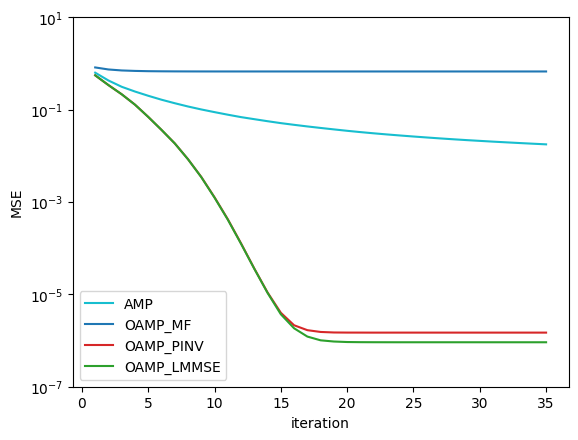

In [ ]:
plt_MSE(tmp_iidG[0].mse, 'AMP', T, 'tab:cyan')
plt_MSE(tmp_iidG[1].mse, 'OAMP_MF', T, 'tab:blue')
plt_MSE(tmp_iidG[2].mse, 'OAMP_PINV', T, 'tab:red')
plt_MSE(tmp_iidG[3].mse, 'OAMP_LMMSE', T, 'tab:green')

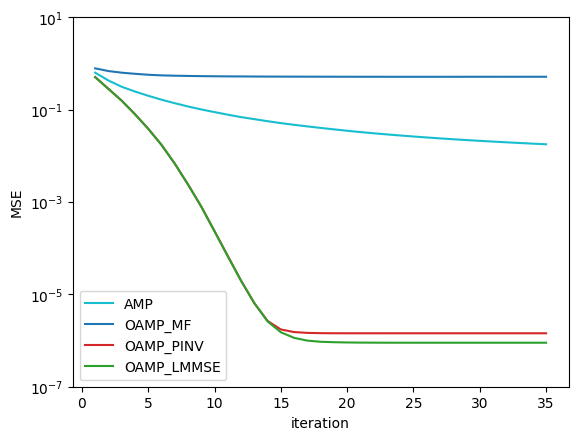

In [ ]:
plt_MSE(tmp_iidG2[0].mse, 'AMP', T, 'tab:cyan')
plt_MSE(tmp_iidG2[1].mse, 'OAMP_MF', T, 'tab:blue')
plt_MSE(tmp_iidG2[2].mse, 'OAMP_PINV', T, 'tab:red')
plt_MSE(tmp_iidG2[3].mse, 'OAMP_LMMSE', T, 'tab:green')

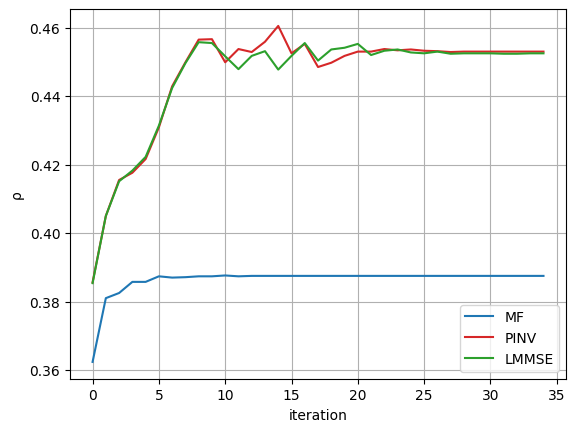

In [ ]:
step = np.arange(0, T+1, 5)

plt.grid()
plt.xlabel("iteration")
plt.ylabel("\u03c1")
plt.xticks(step)


plt.plot(MF_rho, label="MF", color="tab:blue")
plt.plot(PINV_rho, label="PINV", color="tab:red")
plt.plot(LMMSE_rho, label="LMMSE", color="tab:green")
plt.legend()

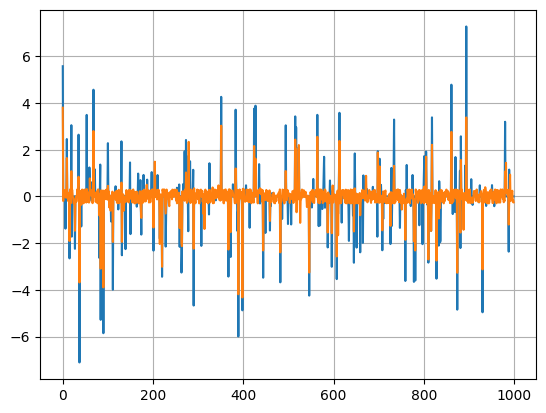

In [ ]:
tmp_iidG[1].result()

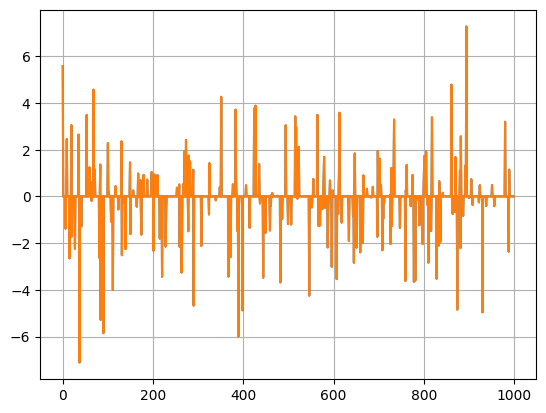

In [ ]:
tmp_iidG[2].result()

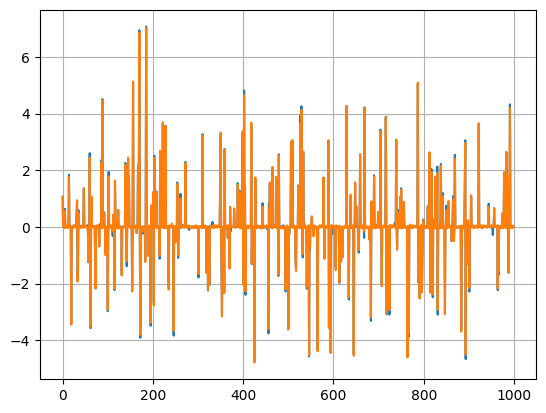

In [ ]:
tmp_iidG[3].result()

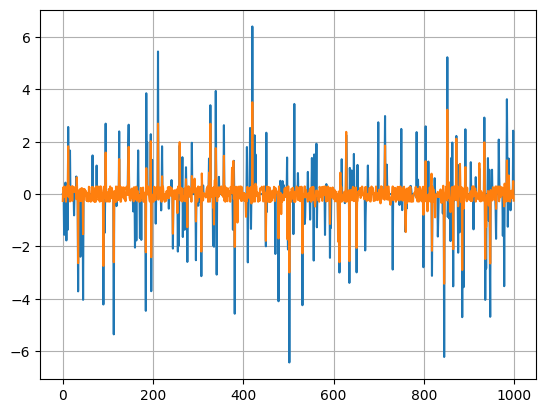

In [ ]:
tmp_iidG2[1].result()

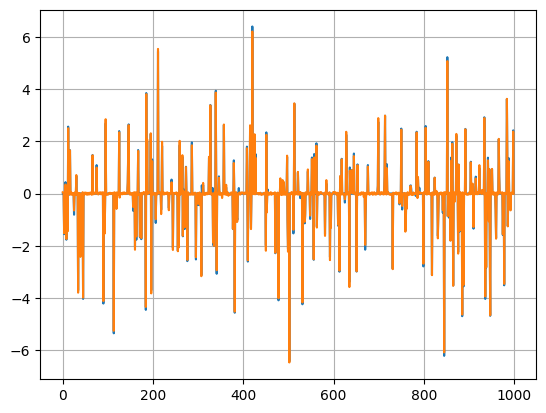

In [ ]:
tmp_iidG2[2].result()

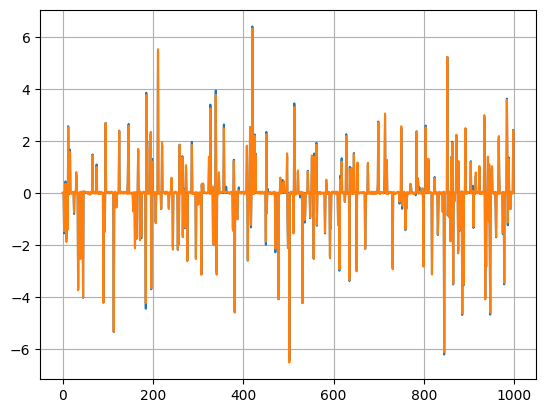

In [ ]:
tmp_iidG2[3].result()

In [ ]:
tmp_UniInv = [OAMP(UniInv.A, x, SNR),
              OAMP_PINV(UniInv.A, x, SNR),
              OAMP_LMMSE(UniInv.A, x, SNR)]

In [ ]:
tmp_UniInv2 = [OAMP2(UniInv.A, x, SNR),
              OAMP_PINV2(UniInv.A, x, SNR),
              OAMP_LMMSE2(UniInv.A, x, SNR)]

In [ ]:
MF_rho2=[]
PINV_rho2=[]
LMMSE_rho2=[]

,0.363
,0.385
,0.388
,0.392
,0.395
,0.395
,0.396
,0.397
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396


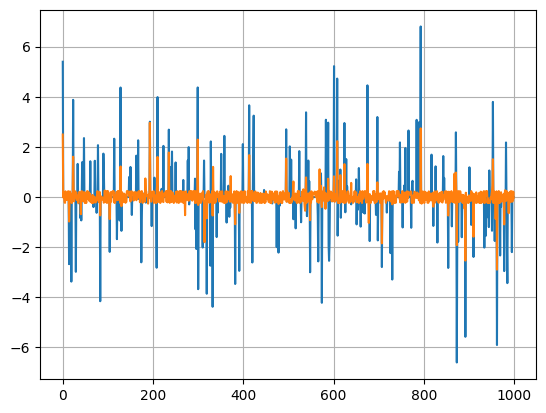

In [ ]:
tmp_UniInv[0].estimate(T=T)
tmp_UniInv[0].result()

,0.384
,0.396
,0.418
,0.411
,0.42
,0.42
,0.438
,0.451
,0.439
,0.453
,0.462
,0.481
,0.424
,0.455
,0.476
,0.464
,0.459
,0.459
,0.456
,0.464
,0.456
,0.454
,0.456
,0.458
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459


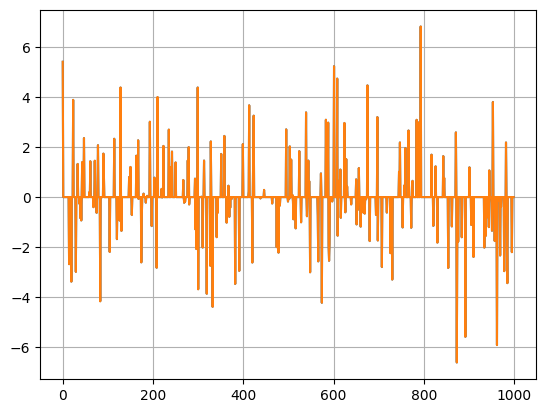

In [ ]:
tmp_UniInv[1].estimate(T=T)
tmp_UniInv[1].result()

,0.383
,0.397
,0.417
,0.413
,0.419
,0.417
,0.438
,0.45
,0.437
,0.452
,0.462
,0.468
,0.418
,0.449
,0.445
,0.444
,0.455
,0.45
,0.45
,0.458
,0.452
,0.454
,0.452
,0.454
,0.454
,0.455
,0.456
,0.455
,0.454
,0.454
,0.454
,0.453
,0.453
,0.453
,0.453


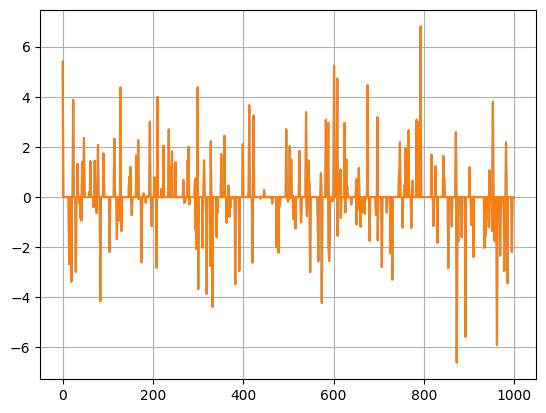

In [ ]:
tmp_UniInv[2].estimate(T=T)
tmp_UniInv[2].result()

In [ ]:
tmp_UniInv2[0].estimate(T=T)
tmp_UniInv2[1].estimate(T=T)
tmp_UniInv2[2].estimate(T=T)

rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2
rho = 0.2


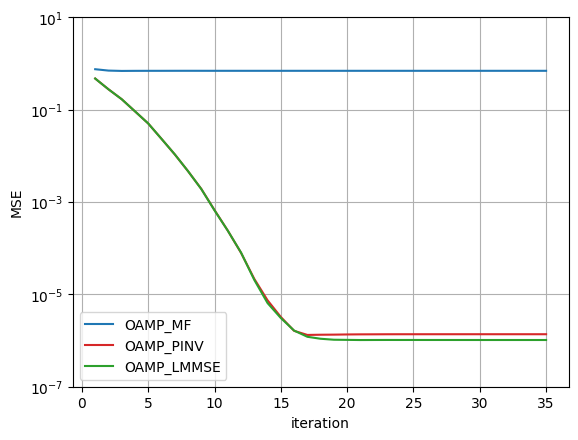

In [ ]:
plt_MSE(tmp_UniInv[0].mse, 'OAMP_MF', T, 'tab:blue')
plt_MSE(tmp_UniInv[1].mse, 'OAMP_PINV', T, 'tab:red')
plt_MSE(tmp_UniInv[2].mse, 'OAMP_LMMSE', T, 'tab:green')

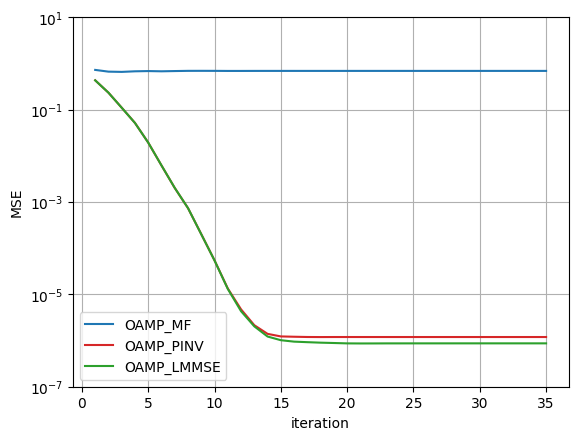

In [ ]:
plt_MSE(tmp_UniInv2[0].mse, 'OAMP_MF', T, 'tab:blue')
plt_MSE(tmp_UniInv2[1].mse, 'OAMP_PINV', T, 'tab:red')
plt_MSE(tmp_UniInv2[2].mse, 'OAMP_LMMSE', T, 'tab:green')

In [ ]:
MF_rho2=[0.363
,0.385
,0.388
,0.392
,0.395
,0.395
,0.396
,0.397
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
,0.396
]

In [ ]:
PINV_rho2=[0.384
,0.396
,0.418
,0.411
,0.42
,0.42
,0.438
,0.451
,0.439
,0.453
,0.462
,0.481
,0.424
,0.455
,0.476
,0.464
,0.459
,0.459
,0.456
,0.464
,0.456
,0.454
,0.456
,0.458
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459
,0.459]

In [ ]:
LMMSE_rho2=[0.383
,0.397
,0.417
,0.413
,0.419
,0.417
,0.438
,0.45
,0.437
,0.452
,0.462
,0.468
,0.418
,0.449
,0.445
,0.444
,0.455
,0.45
,0.45
,0.458
,0.452
,0.454
,0.452
,0.454
,0.454
,0.455
,0.456
,0.455
,0.454
,0.454
,0.454
,0.453
,0.453
,0.453
,0.453]

In [ ]:
np.mean(MF_rho2)

0.3943714285714287

In [ ]:
np.mean(PINV_rho2)

0.44865714285714287

In [ ]:
np.mean(LMMSE_rho2)

0.44365714285714275

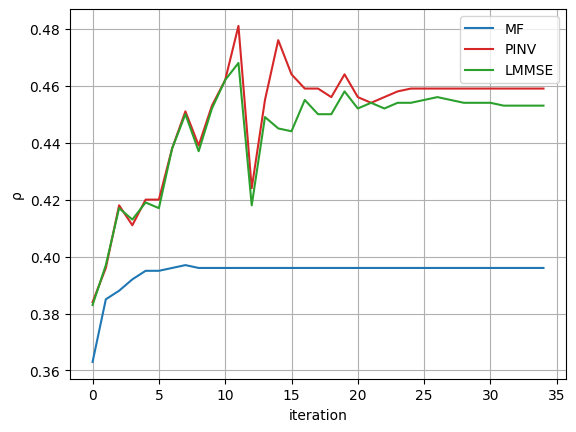

In [ ]:
step = np.arange(0, T+1, 5)

plt.grid()
plt.xlabel("iteration")
plt.ylabel("\u03c1")
plt.xticks(step)


plt.plot(MF_rho2, label="MF", color="tab:blue")
plt.plot(PINV_rho2, label="PINV", color="tab:red")
plt.plot(LMMSE_rho2, label="LMMSE", color="tab:green")
plt.legend()